In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [5]:
def get_melted_pi_counts_table(ver='poder', min_t_cpm=None):
    assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='t_tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    if ver == 'poder':
        f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    elif ver == 'v47':
        f = '../data/analysis/04_relative_abundances_allgenes_gencode.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    
    # add gene expression
    ver = 'poder'
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['gene_tsv'],od))[0]
    gene_df = pd.read_csv(f, sep='\t')
    gene_df.head()
    gene_df.sort_values(by='geneid.v').head()
    gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
    id_vars = ['gid']
    sample_columns = list(set(gene_df.columns)-set(id_vars))
    gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='g_counts')
    gene_df.head()
    
    # filter based on min. cpm
    df = df.merge(gene_df, how='left',
                  on=['gid', 'sample'])
    
    
    if min_t_cpm:
        df = df.loc[df.t_tpm >= min_t_cpm]
        
    return df

In [6]:
df = get_melted_pi_counts_table(ver='poder', min_t_cpm=None)

In [9]:
df.head()

,tid,gid,sample,pi,t_tpm,population,g_counts
0,ENST00000010132.6,ENSG00000010219.14,AJI2,0.32923,16.871600,AJI,649.63419
1,ENST00000013894.3,ENSG00000011198.10,AJI2,0.00000,0.000000,AJI,67.00004
2,ENST00000075120.12,ENSG00000059804.18,AJI2,0.00000,0.000000,AJI,112.00000
3,ENST00000155093.8,ENSG00000067646.12,AJI2,0.40000,0.157767,AJI,5.00000
4,ENST00000156084.8,ENSG00000068308.15,AJI2,0.00000,0.000000,AJI,15.71766


In [7]:
f = '../data/07_differential_expressions/04_DTUres_pantrx.tsv'
dtu_df = pd.read_csv(f, sep='\t')

In [8]:
dtu_df.head()

,geneid.v,contrast,reference,pval,contrast_name,fdr,sigDTU
0,ENSG00000000460.17,CEU,AJI,0.873667,CEUvsAJI,0.942138,155
1,ENSG00000001461.18,CEU,AJI,0.213647,CEUvsAJI,0.693059,155
2,ENSG00000004487.18,CEU,AJI,0.658303,CEUvsAJI,0.861379,155
3,ENSG00000009780.16,CEU,AJI,0.107250,CEUvsAJI,0.575975,155
4,ENSG00000009790.15,CEU,AJI,0.068010,CEUvsAJI,0.500974,155


In [45]:
contrast = list(set(['CEU', 'YRI']))
temp = df.loc[df.population.isin(contrast)]
temp.head()

# get mean pi for each population
temp.drop('sample', axis=1, inplace=True)
temp = temp.groupby(['gid', 'tid', 'population', 'g_counts']).mean().reset_index()
temp.head()

# Pivoting the table
temp = temp.pivot_table(index=['gid', 'tid'], columns='population', values=['g_counts', 'pi', 't_tpm'])

# Flatten the column MultiIndex
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]

# Reset the index if necessary
temp = temp.reset_index()

# calculate delta psi
pi_cols = [c for c in temp.columns if 'pi_' in c]
temp['dpi'] = temp[pi_cols[0]]-temp[pi_cols[1]]
tpm_cols = [c for c in temp.columns if 'tpm_' in c]


# limit to dtu genes
temp_dtu = dtu_df.loc[(dtu_df.contrast==contrast[0])&\
                      (dtu_df.reference==contrast[1])]
if len(temp_dtu.index) ==0:
    temp_dtu = dtu_df.loc[(dtu_df.contrast==contrast[1])&\
                      (dtu_df.reference==contrast[0])]
temp = temp.loc[temp.gid.isin(temp_dtu['geneid.v'].tolist())]

In [46]:
# get, let's say the top 3 pi values for each contrast
temp['abs_dpi'] = np.abs(temp['dpi'])
temp = temp.sort_values(by='abs_dpi', ascending=False)

In [50]:
# impost minimum transcirpt expression threshold
temp = temp.loc[(temp[tpm_cols]>100).any(axis=1)]
temp.head(20).tail(10)

,gid,tid,g_counts_CEU,g_counts_YRI,pi_CEU,pi_YRI,t_tpm_CEU,t_tpm_YRI,dpi,abs_dpi
102301,ENSG00000213145.10,transcript_49784,18680.329808,27887.789292,0.437114,0.792355,711.617600,2325.770500,-0.355241,0.355241
73227,ENSG00000164919.11,transcript_368207,31582.621007,21497.669199,0.850157,0.506913,2185.676000,858.661000,0.343244,0.343244
112071,ENSG00000234745.14,transcript_345602,13915.512663,13241.612096,0.347418,0.028507,326.339014,37.026114,0.318911,0.318911
73951,ENSG00000165678.22,transcript_23778,1351.398724,1631.335218,0.946335,0.655842,100.350880,97.988350,0.290493,0.290493
21931,ENSG00000105373.19,transcript_91252,2931.200742,1220.832438,0.403776,0.124799,103.290080,10.358958,0.278977,0.278977
21932,ENSG00000105373.19,transcript_91257,2931.200742,1220.832438,0.593926,0.872771,125.346289,98.566750,-0.278845,0.278845
101777,ENSG00000206503.15,transcript_156981,4552.613065,5435.426601,0.117546,0.396209,36.675056,211.820100,-0.278662,0.278662
83535,ENSG00000174021.12,transcript_208253,6271.837070,4422.836150,0.947996,0.675039,485.912000,266.502500,0.272957,0.272957
102062,ENSG00000211592.8_ENSG00000239951.1,transcript_301574,1485.413554,16499.726460,0.666832,0.938384,118.918718,1205.050600,-0.271552,0.271552
50884,ENSG00000137731.14,transcript_216823,5058.799440,373.777658,0.831849,0.565084,393.695192,24.380256,0.266764,0.266764


In [82]:
def plot_thing_2(df, gid, tids=[]):
    # expression and pi
    temp = df.loc[df.gid==gid].copy(deep=True)
    
    if len(tids) > 0:
        temp = df.loc[df.tid.isin(tids)]
    
    fig, (ax1, ax2) = plt.subplots(2,1)
    
    c_dict, order = get_population_colors()

    
    # ax = sns.stripplot(temp, hue='tid', x='population', y='pi', alpha=0.5)
    # ax1 = sns.boxplot(temp, hue='tid', x='population',
    #                  y='pi', order=order, ax=ax1)
    ax1 = sns.stripplot(temp, hue='tid', x='population',
                     y='pi', order=order, ax=ax1)
    ax2 = sns.boxplot(temp, x='population', y='g_counts',
                     palette=c_dict, order=order, ax=ax2)
    
    
    sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))  


['transcript_49761' 'transcript_49784']


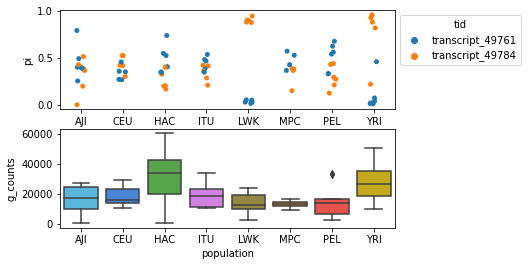

In [83]:
gid = 'ENSG00000213145.10'
tids = df.loc[(df.gid==gid)&(df.pi>=0.4)].tid.unique()
print(tids)
plot_thing_2(df, gid, tids)

['transcript_368207' 'transcript_368182']


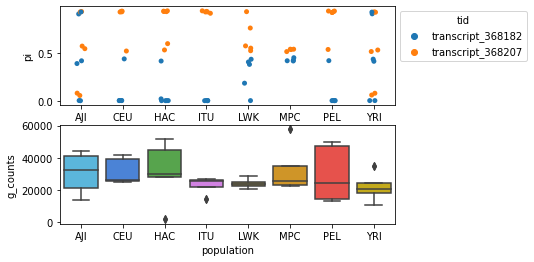

In [84]:
gid = 'ENSG00000164919.11'
tids = df.loc[(df.gid==gid)&(df.pi>=0.4)].tid.unique()
print(tids)
plot_thing_2(df, gid, tids)

In [55]:
gid = 'ENSG00000213145.10'
pop1 = 'CEU'
pop2 = 'YRI'
df.loc[(df.gid==gid)&\
       (df.population.isin([pop1]))&\
       (df.t_tpm>0)].sort_values(by='pi', ascending=False).head()

,tid,gid,sample,pi,t_tpm,population,g_counts
2736366,transcript_49784,ENSG00000213145.10,CEU3,0.523457,845.896,CEU,16125.47468
5783613,transcript_49784,ENSG00000213145.10,CEU4,0.523288,1080.700,CEU,23300.72556
6073819,transcript_49761,ENSG00000213145.10,CEU2,0.455749,402.717,CEU,10731.11281
1285296,transcript_49784,ENSG00000213145.10,CEU5,0.421278,337.108,CEU,13973.43145
4042329,transcript_49784,ENSG00000213145.10,CEU1,0.417046,1028.850,CEU,29270.90454


In [56]:
gid = 'ENSG00000213145.10'
pop1 = 'CEU'
pop2 = 'YRI'
df.loc[(df.gid==gid)&\
       (df.population.isin([pop2]))&\
       (df.t_tpm>0)].sort_values(by='pi', ascending=False).head()

,tid,gid,sample,pi,t_tpm,population,g_counts
4187436,transcript_49784,ENSG00000213145.10,YRI5,0.957800,5596.03,YRI,50960.73458
5493399,transcript_49784,ENSG00000213145.10,YRI6,0.953130,3089.91,YRI,28638.48299
559761,transcript_49784,ENSG00000213145.10,YRI2,0.926026,1979.93,YRI,35221.69584
849975,transcript_49784,ENSG00000213145.10,YRI3,0.880248,1937.37,YRI,24107.17365
704868,transcript_49784,ENSG00000213145.10,YRI7,0.818613,1118.90,YRI,18480.64184


In [49]:
gid = 'ENSG00000081237.22'
pop1 = 'CEU'
pop2 = 'YRI'
df.loc[(df.gid==gid)&\
       (df.population.isin([pop1,pop2]))&\
       (df.t_tpm>0)]

,tid,gid,sample,pi,t_tpm,population,g_counts
572058,transcript_7946,ENSG00000081237.22,YRI2,0.137732,0.635422,YRI,75.99999
572089,transcript_7952,ENSG00000081237.22,YRI2,0.353529,1.631010,YRI,75.99999
572101,transcript_7955,ENSG00000081237.22,YRI2,0.057174,0.263774,YRI,75.99999
572116,transcript_7959,ENSG00000081237.22,YRI2,0.040948,0.188914,YRI,75.99999
572119,transcript_7960,ENSG00000081237.22,YRI2,0.107661,0.496696,YRI,75.99999
...,...,...,...,...,...,...,...
6086118,transcript_7945,ENSG00000081237.22,CEU2,0.004507,0.089076,CEU,239.99958
6086124,transcript_7946,ENSG00000081237.22,CEU2,0.004593,0.090760,CEU,239.99958
6086155,transcript_7952,ENSG00000081237.22,CEU2,0.966573,19.101900,CEU,239.99958
6086167,transcript_7955,ENSG00000081237.22,CEU2,0.004961,0.098037,CEU,239.99958


In [37]:
gid = 'ENSG00000027075.18'
pop1 = 'CEU'
pop2 = 'YRI'
df.loc[(df.gid==gid)&\
       (df.population.isin([pop1,pop2]))&\
       (df.t_tpm>0)]

,tid,gid,sample,pi,t_tpm,population,g_counts
441019,ENST00000557559.1,ENSG00000027075.18,YRI2,1.000000,0.060704,YRI,1.00000
586014,ENST00000555082.6,ENSG00000027075.18,YRI7,1.000000,0.295838,YRI,4.00000
731121,ENST00000555082.6,ENSG00000027075.18,YRI3,0.500000,0.045649,YRI,1.00000
851762,transcript_54308,ENSG00000027075.18,YRI3,0.500000,0.045649,YRI,1.00000
1166442,ENST00000555082.6,ENSG00000027075.18,CEU5,0.055555,0.139984,CEU,44.00004
1287083,transcript_54308,ENSG00000027075.18,CEU5,0.944445,2.379720,CEU,44.00004
3197940,ENST00000555082.6,ENSG00000027075.18,YRI1,0.500000,0.214743,YRI,4.00000
3318581,transcript_54308,ENSG00000027075.18,YRI1,0.500000,0.214743,YRI,4.00000
4044116,transcript_54308,ENSG00000027075.18,CEU1,1.000000,1.179940,CEU,14.00000
4068582,ENST00000555082.6,ENSG00000027075.18,YRI5,0.500000,0.057325,YRI,1.00000
